# Particle Swarm Optimization

* Author: Hamza El-Kebir
* Date: Nov 13, 2020

**Description**

This Python code contains an implementation of the classical particle swarm optimization (PSO) algorithm. Press <kbd>Shift</kbd>+<kbd>Enter</kbd> to run cells in Jupyter Notebooks. A condensed description of the theory is given below. An example is given for minimization on the Rosenbrock function.

In [126]:
import numpy as np
import scipy.sparse, scipy.optimize, scipy.linalg

import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

import cmocean

mpl.rcParams['figure.figsize'] = 10, 10

$\def\bigtimes{\mathop{\vcenter{\huge\times}}}$
# Overview of Particle Swarm Optimization

## 1. Preliminaries

### 1.1 Problem Definition

Any PSO scheme starts with a given number of particles, or agents. Let this number be $N \in \mathbb{N}$. Let the problem space be some subset of $\mathbb{R}^n$, denoted by $\mathscr{X}$.

Let $f : \mathscr{X} \to \mathbb{R}$ be the cost function. Our goal is to find $x^* \in \mathscr{X}$ such that $x^* = \arg\min_{x \in \mathscr{X}} f(x)$. PSO forms a metaheuristic that solves this problem sufficiently well, while not requiring any information on the gradient of $f$; this means that $f$ can be nonsmooth. We therefore obtain $x_{\mathrm{PSO}}^* \approx x^*$ in some sense; not that there is no clear measure that describes the distance between the two variables, as this is dependent on the implementation and choice of tuning parameters, as well as $f$ and the existence of local minima, as well as the initial conditions of the particles.

### 1.2 Agent Initialization

The initial positions of these individual particles, which we denote by the set $\mathcal{I} = {1,\ldots, N}$, are constrained to lie within some given initial space $\mathscr{X}_0 \subseteq \mathscr{X}$. In our implementation, we take this space to be a hyperrectangle $\mathscr{X}_0 = \bigtimes_{i=1}^N [\underline{x}_i, \overline{x}_i]$, where $\underline{x}_i \leq \overline{x}_i$ denote the limits on the dimensions $i \in \{1, \ldots, n\}$.

We initialize the agent positions, denoted by $x^{[i]}$ for agent $i$, as $x^{[i]} = U(\underline{x}, \overline{x}) \in \mathscr{X}_0$, where $U(l, u)$ denotes the realization of a uniform distribution with limits $l, u$. In addition, we initialize the agent velocity $v^{[i]}$ to be $v^{[i]} = U(-|\overline{x} - \underline{x}|, |\overline{x} - \underline{x}|)$, where $|\cdot|$ denotes the element-wise absolute value, i.e. $|x|_i = |x_i|$. In short, the initial state of each variable is random, but bounded by the set of initial states.

We also initialize the personal best position of each agent. Since each variable has only visited a single location, the current position and cost will be the personal best. We denote this personal best position by $p^{[i]} = x^{[i]}$ for $i \in \mathcal{I}$, while the personal best cost is denoted by $c_p^{[i]} = f(p^{[i]})$.

Finally, a global best cost and the corresponding position are initialized. We denote this position by $g = \arg\min_{x^{[i]} : i \in \mathcal{I}} f(x^{[i]})$, while the global best cost is denoted by $c_g = \min\{ f(x^{[i]}) : i \in \mathcal{I} \}$.

## 2. Main Iteration

The main iteration loops through each agent $i \in \mathcal{I}$, assigns a velocity $v^{[i]}$, updates the current position $x^{[i]}$ and personal best position $p^{[i]}$ of each agent, as well as the global best position $g$. The key to this procedure is the definition of the velocity, which is defined in an element-wise fashion for each agent as follows:

$$v^{[i]}_d = \omega v^{[i]}_d + \phi_p r_p (p^{[i]}_d - x^{[i]}) + \phi_g r_g (g_d - x^{[i]}), \tag{2.1},$$

for all $d \in \{1, \ldots, n\}$. Here, $\omega$ denotes the inertia, $\phi_p$ the gravity of the agent's personal influence, and $\phi_g$ the gravity of the global influence. All of these values are positive. $r_p$ and $r_g$ denote realizations of $U(0, 1)$, and regulate the influence of the personal best and global best position; these values are regenerated for each dimension $d$. If $\phi_p$ is taken to be large, the agent will attempt to move back to its past personal best. If $\phi_g$ is taken to be large, the agent will gravitate towards the global best position. Finally, some of the past velocity is carried over, as can be tuned by the inertia $\omega$.

The position is then updated by $x^{[i]} = x^{[i]} + \alpha v^{[i]}$, where $\alpha \in (0, 1]$ is the learning rate. For a given agent, if $f(x^{[i]}) < c_p^{[i]}$, i.e. the current cost is lower than the personal best cost, we update the personal best position as $p^{[i]} = x^{[i]}$ and the personal best cost as $c_p^{[i]} = f(p^{[i]})$. If $c_p^{[i]} < c_g$, we update the global best position as $g = p^{[i]}$ and the global best cost as $c_g = c_p^{[i]}$.

## 3. Example

We consider as the cost function the Rosenbrock function $f(x) = (1 - x_1)^2 + 100 (x_2 - x_1^2)^2$, which has its global minimum at $(1, 1)$. We initialize 100 agents in the region $[-3, 3] \times [-3, 3]$, and apply an inertia $\omega = 0.5$, personal influence $\phi_p = 0.1$, and global influence $\phi_g = 0.7$. We run 200 iterations. The results are shown below, with the global best converging to $(1, 1)$.

In [46]:
class Particle(object):
    def __init__(self, pos, pso, trackHistory=False):
        self.pso = pso
        
        self.trackHistory = trackHistory
        self.p_l = []
        self.v_l = []
        
        self.pos = pos
        self.bestPos = np.copy(pos)
        self.bestCost = pso.costFunction(pos)
        
        velRange = np.abs(pso.hiBound-pso.loBound)
        self.velocity = np.random.uniform(-velRange, velRange)
       
    @property
    def pos(self):
        return self.p
    
    @pos.setter
    def pos(self, p):
        self.p = p
        
        if self.trackHistory:
            self.p_l.append(np.copy(p))
    
    @property
    def velocity(self):
        return self.v
    
    @velocity.setter
    def velocity(self, v):
        self.v = v
        
        if self.trackHistory:
            self.v_l.append(np.copy(v))
        
    def updatePosition(self):
        self.pos += self.pso.learningRate*self.velocity

class PSO(object):
    def __init__(self, loBound, hiBound, costFunction, trackHistory=False):
        if (len(loBound) != len(hiBound)):
            raise ValueError(f"Lower bound and higher bound dimensions do not match: {len(loBound)} != {len(hiBound)}")
        else:
            self.loBound = np.asarray(loBound)
            self.hiBound = np.asarray(hiBound)
            self.dim = len(loBound)
            
        self.costFunction = costFunction
        
        self.trackHistory = trackHistory
        
        self.learningRate = 1
        self.particles = []
        
        self.inertia = 1
        self.personalInfluence = 0.5
        self.globalInfluence = 2
        
        self.globalBestCost = np.inf
        self.globalBestPos = np.random.uniform(self.loBound, self.hiBound)
        
    def initGlobalBest(self):
        for p in self.particles:
            cost = self.costFunction(p.bestPos)
            
            if cost < self.globalBestCost:
                self.globalBestCost = cost
                self.globalBestPos = np.copy(p.bestPos)
        
    def initParticles(self, N=100):
        for i in range(N):
            particle = Particle(np.random.uniform(self.loBound, self.hiBound), self, self.trackHistory)
            self.particles.append(particle)
        
        self.initGlobalBest()
        
    def iterate(self):
        for p in self.particles:
            for d in range(self.dim):
                rp = np.random.uniform()
                rg = np.random.uniform()
                
                p.velocity[d] = self.inertia*p.velocity[d] + self.personalInfluence*rp*(p.bestPos[d] - p.pos[d]) + self.globalInfluence*rg*(self.globalBestPos[d] - p.pos[d])
                
            p.pos += self.learningRate*p.velocity
            
            cost = self.costFunction(p.pos)
            
            if cost < p.bestCost:
                p.bestPos = np.copy(p.pos)
                p.bestCost = cost
                
                if p.bestCost < self.globalBestCost:
                    self.globalBestPos = np.copy(p.bestPos)
                    self.globalBestCost = p.bestCost
                    
    def iterateN(self, N=100):
        for _ in range(N):
            self.iterate()
            
        return (self.globalBestPos, self.globalBestCost)

In [47]:
def genRosenbrock(a=1, b=100):
    rosenbrock = lambda x : (a - x[0])*(a - x[0]) + b*(x[1] - x[0]*x[0])*(x[1] - x[0]*x[0])
    
    return rosenbrock

rosenbrock = genRosenbrock(a=1, b=100)

pso = PSO(loBound=[-3, -3], hiBound=[3, 3], costFunction=rosenbrock, trackHistory=True)
pso.initParticles(100)
pso.inertia = 0.5
pso.personalInfluence = 0.1
pso.globalInfluence = 0.7
pso.iterateN(200)

(array([1., 1.]), 0.0)

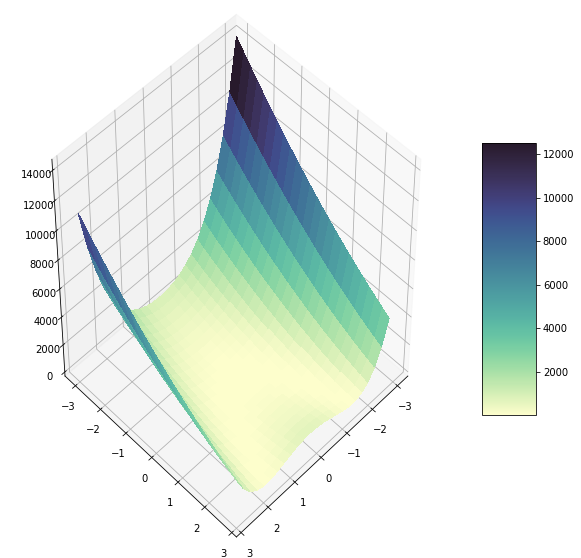

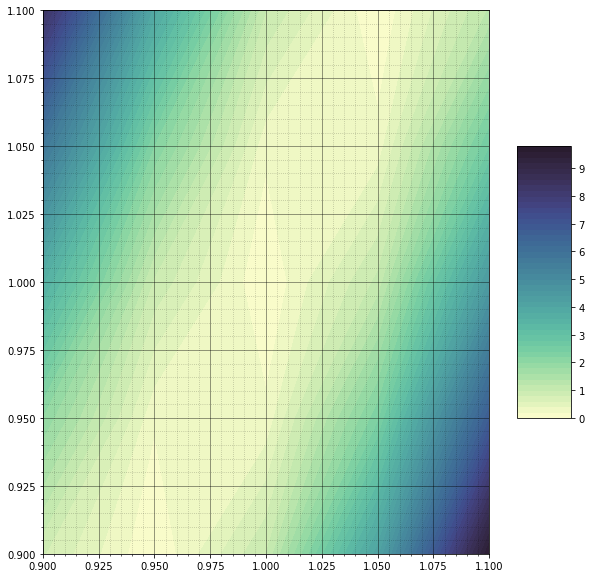

In [147]:
fig = plt.figure()
ax = fig.gca(projection='3d')

# 3D SURFACE PLOT
X = np.arange(-3, 3, 0.25)
Y = np.arange(-3, 3, 0.25)
X, Y = np.meshgrid(X, Y)
Z = (1 - X)*(1 - X) + 100*(Y - X*X)*(Y - X*X)

surf = ax.plot_surface(X, Y, Z, cmap=cmocean.cm.deep,
                       linewidth=0, antialiased=False)

ax.view_init(45, 45)

fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

# CONTOUR PLOT

X = np.arange(0.9, 1.1, 0.05)
Y = np.arange(0.9, 1.1, 0.05)
X, Y = np.meshgrid(X, Y)
Z = (1 - X)*(1 - X) + 100*(Y - X*X)*(Y - X*X)

fig = plt.figure()
ax = fig.gca()

# Plot the surface.
surf = ax.contourf(X, Y, Z, 50, cmap=cmocean.cm.deep, antialiased=False)

fig.colorbar(surf, shrink=0.5, aspect=5)

plt.minorticks_on()
plt.grid(which='minor', color='k', alpha=0.25, linestyle=':')
plt.grid(which='major', color='k', alpha=0.5)

plt.show()

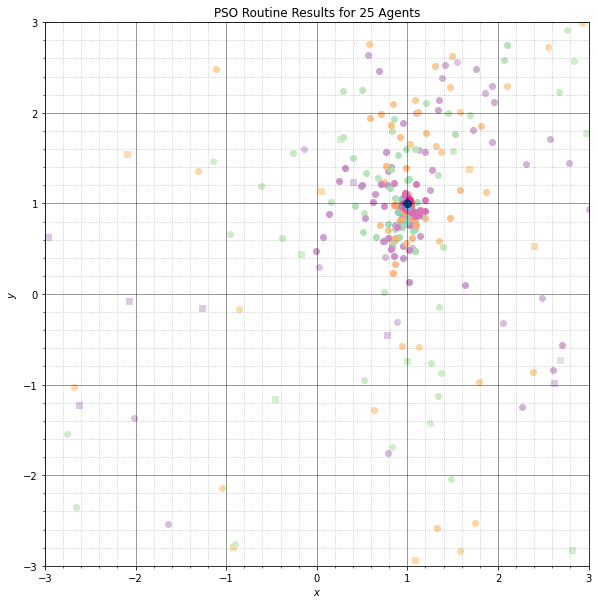

In [149]:
plt.axes().set_aspect('equal')

cmaps = [plt.get_cmap("PuRd"), plt.get_cmap("GnBu"), plt.get_cmap("OrRd"), plt.get_cmap("YlGn")]
N = len(pso.particles[0].p_l)
valMap = lambda i : 50 + int((i/N)*950)

for i in range(N):
    if i == 0:
        m = 's'
    elif i == N-1:
        m = 'D'
    else:
        m = 'o'

    for idx, p in enumerate(pso.particles[:20]):
        cmap = cmaps[idx % (len(cmaps)-1)]
        c = cmap(valMap(i))
            
        plt.scatter(p.p_l[i][0], p.p_l[i][1], color=c, marker=m)
    
plt.xlim([-3, 3])
plt.xlabel('$x$')
plt.ylim([-3, 3])
plt.ylabel('$y$')
plt.minorticks_on()
plt.grid(which='minor', color='k', alpha=0.25, linestyle=':')
plt.grid(which='major', color='k', alpha=0.5)
plt.title("PSO Routine Results for 25 Agents")
plt.show()